In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import math
import re
import spacy
from spacy.symbols import ORTH
import itertools
from functools import partial
from collections import Iterable
from tqdm import tqdm as tqdm_cls, tqdm_notebook, tnrange

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim, multinomial, save, load

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from sklearn.model_selection import train_test_split
import dill as pickle
import io
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
SEED = 123456

In [4]:
!ls data

sample_submission.csv  train.csv  trn_txt.csv  val_txt.csv
test.csv	       trn.csv	  val.csv


In [5]:
# Look at training data
cmt = pd.read_csv('data/train.csv')
cmt.shape

(95851, 8)

In [6]:
cmt.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [7]:
labels = cmt.columns[2:]

In [8]:
cmt[labels].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000,95851.000000
mean,0.096368,0.010068,0.053301,0.003182,0.049713,0.008492
std,0.295097,0.099832,0.224635,0.056320,0.217352,0.091762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
cmt['num_labels'] = cmt[labels].sum(axis=1)
cmt['num_labels'].describe()

count    95851.000000
mean         0.221124
std          0.750533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.000000
Name: num_labels, dtype: float64

In [10]:
# Define tokenizer
# https://github.com/fastai/fastai/blob/dc61200b18f25a42b8e803c5ca7be48509f562ef/fastai/nlp.py#L16-L21
re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)

def sub_br(x):
    return re.sub(r'\n', ' ', re_br.sub(' ', x))

def sub_quote(x):
    return re.sub(r'"', ' ', x)

my_tok = spacy.load('en')
my_tok.tokenizer.add_special_case('<eos>', [{ORTH: '<eos>'}])

def spacy_tok(x):
    return [tok.text for tok in my_tok.tokenizer(sub_quote(sub_br(x)))]



    Only loading the 'en' tokenizer.



In [11]:
# Clean text
cmt['comment_text_cleaned'] = [' '.join(spacy_tok(txt)).strip() for txt in cmt['comment_text']]
cmt[['comment_text', 'comment_text_cleaned']].head()

,comment_text,comment_text_cleaned
0,"Nonsense? kiss off, geek. what I said is true...","Nonsense ? kiss off , geek . what I said is ..."
1,"""\n\n Please do not vandalize pages, as you di...","Please do not vandalize pages , as you did wit..."
2,"""\n\n """"Points of interest"""" \n\nI removed the...",Points of interest I removed the point...
3,Asking some his nationality is a Racial offenc...,Asking some his nationality is a Racial offenc...
4,The reader here is not going by my say so for ...,The reader here is not going by my say so for ...


In [12]:
# Split into training and validation set
cmt_trn, cmt_val, cmt_trn_y, cmt_val_y = train_test_split(cmt[['id', 'comment_text_cleaned']], cmt[labels], random_state=SEED)
cmt_trn.shape, cmt_val.shape, cmt_trn_y.shape, cmt_val_y.shape

((71888, 2), (23963, 2), (71888, 6), (23963, 6))

In [13]:
cmt_trn = cmt_trn.join(cmt_trn_y)
cmt_val = cmt_val.join(cmt_val_y)

In [15]:
# Save only the text content
cmt_trn['comment_text_cleaned'].to_csv('data/trn_txt.csv', index=False, header=False)
cmt_val['comment_text_cleaned'].to_csv('data/val_txt.csv', index=False, header=False)

In [126]:
# Save a small subset of data for testing code only
cmt_trn['comment_text_cleaned'][:1000].to_csv('data/trn_txt_small.csv', index=False, header=False)
cmt_val['comment_text_cleaned'][:1000].to_csv('data/val_txt_small.csv', index=False, header=False)

## Create language model

### Create text field and splits

In [4]:
# Create a torchtext field
TEXT = data.Field(lower=True, eos_token='<eos>')

In [5]:
# Create splits
trn, val = data.TabularDataset.splits(
    path='data',
    train='trn_txt.csv',
    validation='val_txt.csv',
#     train='trn_txt_small.csv',
#     validation='val_txt_small.csv',
    format='csv',
    fields=[('text', TEXT)])

In [6]:
len(trn), len(val)

(71888, 23963)

In [7]:
# Build vocabulary
TEXT.build_vocab(trn, min_freq=10)

In [8]:
# Vocabulary size
vocab_size = len(TEXT.vocab)
vocab_size

16629

In [9]:
# Vocabulary dict
# Most frequent words
TEXT.vocab.itos[:10]

['<unk>', '<pad>', '<eos>', '.', 'the', ',', 'to', 'i', 'of', 'and']

In [10]:
# Least frequent words
TEXT.vocab.itos[-10:]

['zurich', 'zzuuzz', '|b', '~*~', '\x93', '—aco', '•talk•', '☠', '✄', '😉']

In [11]:
# Check out the first sentence in the training set
trn.examples[0].text[:20]

['tag',
 'brewcrewer',
 ',',
 'if',
 'you',
 'do',
 'nt',
 'want',
 'to',
 'edit',
 'war',
 'over',
 'something',
 'like',
 'this',
 'why',
 'are',
 'you',
 'reverting',
 '?']

In [12]:
# Check out comment lengths
pd.Series([len(txt.text) for txt in trn.examples]).describe()

count    71888.000000
mean        78.877003
std        119.938922
min          1.000000
25%         20.000000
50%         42.000000
75%         87.000000
max       4948.000000
dtype: float64

In [55]:
pickle.dump(TEXT, open('data/TEXT.pkl','wb'))

### Create iterators

In [13]:
# https://github.com/fastai/fastai/blob/master/fastai/nlp.py#L117
class LanguageModelIterator():
    def __init__(self, ds, bs, bptt):
        self.bs = bs
        self.bptt = bptt

        # Combine all tokens
        toks = [tok.text for tok in ds]
        toks = list(itertools.chain(*toks))

        # Convert tokens to index
        fld = ds.fields['text']
        idx = fld.numericalize([toks])

        # Split into batches
        self.data = self.batchify(idx)
        self.n_toks_per_batch = len(self.data)

        # To point to the index of the next token
        self.i = 0

        # To track iterations
        self.iter = 0

    def __iter__(self):
        self.i = 0
        self.iter = 0
        return self

    def __len__(self):
        # Number of iterations to go over an epoch
        return self.n_toks_per_batch // self.bptt - 1

    def __next__(self):
        if self.i >= self.n_toks_per_batch - 1 or self.iter >= len(self):
            raise StopIteration

        # Halve `bptt` 5% of the time
        bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.

        # Add variability to sequence length
        seq_len = max(5, int(np.random.normal(bptt, 5)))

        res = self.get_batch(self.i, seq_len)
        
        # Update pointers
        self.i += seq_len
        self.iter += 1
        return res

    # Split data into batches
    def batchify(self, toks):
        n_toks_per_batch = len(toks) // self.bs

        # Discard the trailing tokens
        toks = toks[:n_toks_per_batch * bs]

        # Reshape to (n_toks_per_batch, bs)
        toks_reshaped = toks.view(bs, -1).t().contiguous()
        return toks_reshaped.cuda()
    
    # Get the next batch
    def get_batch(self, i, seq_len):
        data = self.data
        seq_len = min(seq_len, self.n_toks_per_batch - i - 1)
        
        # Offset output by 1 token
        return data[i:i + seq_len], data[i + 1:i + 1 + seq_len].view(-1)

In [14]:
bs = 64
bptt = 30

In [15]:
# Create data loaders
trn_dl, val_dl = [LanguageModelIterator(ds, bs, bptt) for ds in (trn, val)]

In [16]:
# Number of iterations
len(trn_dl), len(val_dl)

(2952, 977)

In [17]:
# Check out a batch
X, y = next(iter(trn_dl))
X.shape, y.view(-1, bs).shape

(torch.Size([19, 64]), torch.Size([19, 64]))

### Encoder

In [18]:
# https://github.com/fastai/fastai/blob/5c9ea4c3533a132b45c1ec577c2cbb72ab24d4c0/fastai/lm_rnn.py#L18
def repackage_var(h):
    # Wraps h in new Variables, to detach them from their history.
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_var(v) for v in h)

In [19]:
# Loosely based on https://github.com/fastai/fastai/blob/master/fastai/lm_rnn.py#L23
class RNN_Encoder(nn.Module):
    def __init__(self, bs, vocab_size, embedding_size, hidden_size, n_layers, padding_idx,
                 dropout_embedding, dropout_lstm):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=padding_idx)
        
        # Embedding dropout
        self.embedding_dropout = nn.Dropout(p=dropout_embedding)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout = dropout_lstm)
        
        self.bs, self.hidden_size, self.n_layers = bs, hidden_size, n_layers
    
    def forward(self, input):
        input_embedded = self.embedding_dropout(self.embedding(input))  # (seq_len, bs, embedding_size)
        output, hidden = self.lstm(input_embedded, self.hidden)  # (seq_len, bs, hidden_size)
        self.hidden = repackage_var(hidden)
        return output
    
    def reset_hidden(self):
        weight = next(self.parameters()).data
        self.hidden = (Variable(weight.new(self.n_layers, self.bs, self.hidden_size).zero_()),
                       Variable(weight.new(self.n_layers, self.bs, self.hidden_size).zero_()))

In [20]:
embedding_size = 200
padding_idx = TEXT.vocab.stoi[TEXT.pad_token]
dropout_embedding = 0.02
dropout_lstm = 0.05
hidden_size = 500
n_layers = 3

In [21]:
# Create encoder instance
rnn_encoder = RNN_Encoder(bs, vocab_size, embedding_size, hidden_size, n_layers, padding_idx, dropout_embedding, dropout_lstm)
rnn_encoder

RNN_Encoder(
  (embedding): Embedding(16629, 200, padding_idx=1)
  (embedding_dropout): Dropout(p=0.02)
  (lstm): LSTM(200, 500, num_layers=3, dropout=0.05)
)

In [22]:
# Test encoder
rnn_encoder_test = rnn_encoder.cuda()
rnn_encoder_test.reset_hidden()
rnn_encoder_test(X).shape

torch.Size([19, 64, 500])

### Decoder

In [23]:
# https://github.com/fastai/fastai/blob/master/fastai/lm_rnn.py#L134
class RNN_Decoder_LM(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super().__init__()
        
        # Linear layer
        self.decoder = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input):
        return self.decoder(input).view(-1, vocab_size)

In [24]:
# Create Decoder instance
rnn_decoder_lm = RNN_Decoder_LM(hidden_size, vocab_size)
rnn_decoder_lm

RNN_Decoder_LM(
  (decoder): Linear(in_features=500, out_features=16629)
)

In [25]:
# Test decoder
rnn_decoder_lm_test = rnn_decoder_lm.cuda()
rnn_decoder_lm_test(rnn_encoder_test(X)).shape

torch.Size([1216, 16629])

### Combine

In [26]:
# https://github.com/fastai/fastai/blob/master/fastai/lm_rnn.py#L197
class SequentialRNN(nn.Sequential):
    # Add function to reset hidden state
    # (Similar to eval(), to be used in evaluation)
    def reset_hidden(self):
        for c in self.children():
            if hasattr(c, 'reset_hidden'): c.reset_hidden()

In [27]:
rnn_lm = SequentialRNN(rnn_encoder, rnn_decoder_lm)

In [28]:
rnn_lm = rnn_lm.cuda()
rnn_lm

SequentialRNN(
  (0): RNN_Encoder(
    (embedding): Embedding(16629, 200, padding_idx=1)
    (embedding_dropout): Dropout(p=0.02)
    (lstm): LSTM(200, 500, num_layers=3, dropout=0.05)
  )
  (1): RNN_Decoder_LM(
    (decoder): Linear(in_features=500, out_features=16629)
  )
)

## Create learner object

In [29]:
# Clear progress bar (for display purpose)
# https://github.com/fastai/fastai/blob/49ff2c3cc66d5ce90e1dbe697f09d690d43b81fc/fastai/imports.py#L29
def clear_tqdm():
    inst = getattr(tqdm_cls, '_instances', None)
    if not inst: return
    for i in range(len(inst)): inst.pop().close()

In [30]:
def accuracy(preds, targs):
    preds = np.argmax(preds, axis=1)
    return (preds==targs).mean()

### Layer optimizer

In [31]:
wds = None
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
# opt = optim.Adam(model.parameters(), betas=(0.7, 0.99), lr = lrs, weight_decay=0)

In [32]:
# https://github.com/fastai/fastai/blob/master/fastai/layer_optimizer.py#L8
class LayerOptimizer():
    def __init__(self, layer_groups, opt_fn, lrs, wds=None):
        # Initialize inputs
        if not isinstance(layer_groups, Iterable):
            layer_groups = [layer_groups]
        if not isinstance(lrs, Iterable):
            lrs = [lrs]
        if wds is None:
            wds = 0
        if not isinstance(wds, Iterable):
            wds = [wds]

        # If only one lrs is given, repeat it to every layer
        if len(lrs) == 1:
            lrs = lrs * len(layer_groups)

        # If only one wds is given, repeat it to every layer
        if len(wds) == 1:
            wds = wds * len(layer_groups)

        # Extract trainable parameters from each layer group
        layer_params = [[p for p in m.parameters() if p.requires_grad]
                        for m in layer_groups]

        # Put all optimizer parameters together, one per layer
        opt_params = [{
            'params': layer_param,
            'lr': lr,
            'weight_decay': wd
        } for layer_param, lr, wd in zip(layer_params, lrs, wds)]

        # Send the parameters to the optimizer function to create the optimizer
        self.opt = opt_fn(opt_params)
        self.lrs = lrs
        self.last_lr = lrs[-1]
    
    # Update learning rate
    def set_lrs(self, lrs):
        if not isinstance(lrs, Iterable):
            lrs = [lrs]
        if len(lrs) == 1:
            lrs = lrs * len(self.opt.param_groups)
        
        for param_group, lr in zip(self.opt.param_groups, lrs):
            param_group['lr'] = lr
        
        self.lrs = lrs
        self.last_lr = lrs[-1]

### Model fitting

In [33]:
crit = F.cross_entropy
metrics = accuracy

In [34]:
# https://github.com/fastai/fastai/blob/master/fastai/model.py#L64
def fit(model, trn_dl, val_dl, layer_opt, crit, metrics, epochs, callback):
    # Initialize parameters
    batch_num = 0
    avg_loss_trn = 0
    avg_mom = 0.98  # Rolling weight used in computing rolling average loss
    opt = layer_opt.opt
    callback.on_train_begin()
    
    # Clear progress bar
    clear_tqdm()

    for epoch in tnrange(epochs, desc='Epoch'):
        # Set model to training mode
        model.train()

        # Reset hidden states for RNN
        model.reset_hidden()

        # Create iterables and set progress bar
        t = tqdm_cls(iter(trn_dl), leave=False, total=len(trn_dl))

        for (x, y) in t:
            batch_num += 1

            # Reset gradients
            opt.zero_grad()

            # Generate predictions for training data
            y_pred = model(x)

            # Compute loss
            loss_trn = crit(y_pred, y)
            
            # Compute gradients
            loss_trn.backward()

            # Update parameters
            opt.step()
            
            # Compute average loss
            avg_loss_trn = avg_loss_trn * avg_mom + loss_trn.data[0] * (1 - avg_mom)
            debias_loss_trn = avg_loss_trn / (1 - avg_mom**batch_num)
            t.set_postfix(loss=debias_loss_trn)
            
            # Record loss, update learning rate (if needed)
            callback.on_batch_end(debias_loss_trn, layer_opt.last_lr)
            
        # Validation
        model.eval()
        model.reset_hidden()
        
        losses_val = []
        metrics_val = []
        
        for (x, y) in iter(val_dl):
            # Generate predictions for validation data
            y_pred = model(x)

            # Compute loss
            loss_val = crit(y_pred, y)
            losses_val.append(loss_val.data.cpu().numpy())
            
            # Compute metrics
            metric_val = metrics(y_pred.data.cpu().numpy(), y.data.cpu().numpy())
            metrics_val.append(metric_val)
        
        # Compute average validation loss and metrics
        avg_loss_val = np.mean(losses_val)
        avg_metrics_val = np.mean(metrics_val)
        
        # Print training loss, validation loss, and validation accuracy
        print(np.round([epoch, debias_loss_trn, avg_loss_val, avg_metrics_val], 4))

### Callbacks

In [35]:
# https://github.com/fastai/fastai/blob/master/fastai/sgdr.py
class LossRecorder:
    def __init__(self, layer_opt):
        self.layer_opt = layer_opt
        self.init_lrs = layer_opt.lrs
    
    def on_train_begin(self):
        self.iteration = 0
        self.iterations = []
        self.losses = []
        self.lrs = []
    
    def on_batch_end(self, loss, last_lr):
        self.iteration += 1
        self.iterations.append(self.iteration)
        self.losses.append(loss)
        self.lrs.append(last_lr)
    
    def plot_lr(self):
        plt.plot(self.iterations, self.lrs)
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
    
    def plot_loss(self):
        plt.plot(self.iterations, self.losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
    
    def plot_loss_vs_lr(self):
        plt.plot(self.lrs, self.losses)
        plt.xlabel('Learning rate (log)')
        plt.ylabel('Loss')
        plt.xscale('log')

### Learning rate finder

In [36]:
class LearningRateFinder(LossRecorder):
    def __init__(self, layer_opt, num_iters, start_lr=1e-5, end_lr=1):
        super().__init__(layer_opt)
        
        # Computes the learing rate multiplier upon the completion of each iterations
        self.lr_mult = (end_lr / start_lr)**(1 / num_iters)
    
    def update_lr(self):
        return np.array(self.init_lrs) * self.lr_mult**self.iteration
    
    def on_batch_end(self, loss, last_lr):
        super().on_batch_end(loss, last_lr)
        self.layer_opt.set_lrs(self.update_lr())

In [37]:
# Save the original model to come back to
save(rnn_lm.state_dict(), 'data/tmp')

In [40]:
start_lr = 1e-5
layer_opt = LayerOptimizer([rnn_lm], opt_fn, start_lr)
learning_rate_finder = LearningRateFinder(layer_opt, len(trn_dl), start_lr)

In [41]:
fit(rnn_lm, trn_dl, val_dl, layer_opt, crit, metrics, 1, learning_rate_finder)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[  0.       8.5781  12.7077   0.    ]



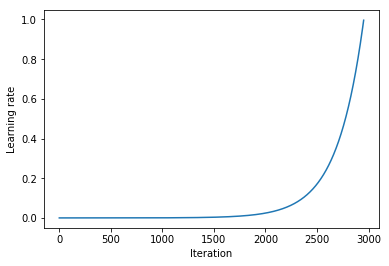

In [42]:
# Plot iterations vs. LR
learning_rate_finder.plot_lr()

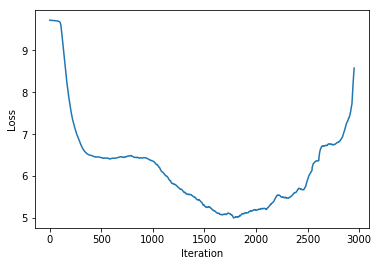

In [43]:
learning_rate_finder.plot_loss()

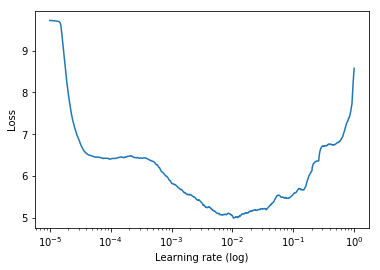

In [44]:
# Plot learning rate vs. losses
learning_rate_finder.plot_loss_vs_lr()

In [45]:
lrs = 1e-3

In [46]:
# Load the original, untrained model
rnn_lm.load_state_dict(load('data/tmp', map_location=lambda storage, loc: storage))

### Cosine annealing

In [47]:
class CosAnneal(LossRecorder):
    def __init__(self, layer_opt, num_iters, cycle_mult=1):
        super().__init__(layer_opt)
        
        self.num_iters = num_iters
        self.cycle_iter = 0
        self.cycle_mult = cycle_mult
    
    def update_lr(self):
        if self.cycle_iter == self.num_iters:
            self.cycle_iter = 0
            self.num_iters *= self.cycle_mult
        
        cos = np.cos(np.pi * self.cycle_iter / self.num_iters) + 1
        self.cycle_iter += 1
        
        return np.array(self.init_lrs) * cos / 2
    
    def on_batch_end(self, loss, last_lr):
        super().on_batch_end(loss, last_lr)
        self.layer_opt.set_lrs(self.update_lr())

In [48]:
cycle_mult = 2
n_cycle = 2

layer_opt = LayerOptimizer([rnn_lm], opt_fn, lrs)
cos_anneal = CosAnneal(layer_opt, len(trn_dl), cycle_mult)
epochs = n_cycle if cycle_mult == 1 else math.ceil((1 - cycle_mult**n_cycle) / (1 - cycle_mult))

In [49]:
fit(rnn_lm, trn_dl, val_dl, layer_opt, crit, metrics, epochs, cos_anneal)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 1/2952 [00:00<08:05,  6.08it/s, loss=5.08]   

[ 0.      5.0777  4.9408  0.2073]


  0%|          | 1/2952 [00:00<06:42,  7.33it/s, loss=4.6]    

[ 1.      4.5925  4.6348  0.2439]


[ 2.      4.4885  4.5485  0.2538]



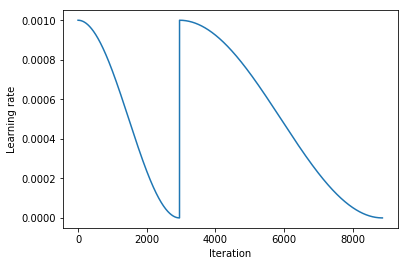

In [50]:
cos_anneal.plot_lr()

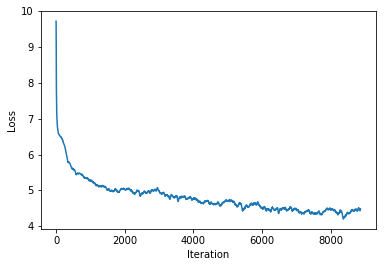

In [51]:
cos_anneal.plot_loss()

In [53]:
# Save model
save(rnn_lm.state_dict(), 'data/rnn_lm')

# Save encoder specifically
save(rnn_lm[0].state_dict(), 'data/rnn_lm_encoder')

### Text generation

In [61]:
def sample_model(fld, model, seed_str, output_len=100):
    # Process the seed string
    seed_str_toks = fld.preprocess(fld.tokenize(seed_str))
    seed_str_toks_num = fld.numericalize([seed_str_toks])

    # Set batch size to 1
    model[0].bs = 1

    # Turn off dropoff (eval mode)
    model.eval()

    # Reset hidden states
    model.reset_hidden()

    # Generate initial predictions
    pred = model(seed_str_toks_num)
    print('...', end='')

    for i in range(output_len):
        # Get the last predictions
        pred_last = pred[-1]
        
        # Compute probabilities using softmax
        pred_last_prob = pred[-1].exp() / pred[-1].exp().sum()
        
        # Randomly sample one word per the distribution
        pred_last_choice = multinomial(pred_last_prob, 1)
        
        # Convert it to word
        word = fld.vocab.itos[pred_last_choice.data[0]]
        print(word, end=' ')

        if word == '<eos>':
            break

        # Generate the next predictions
        pred = model(pred_last_choice.unsqueeze(0))
    
    # Restore encoder batch size
    model[0].bs = bs

In [62]:
seed_str = ' '.join(val.examples[0].text)
print(seed_str)
sample_model(TEXT, rnn_lm, seed_str)

plagiarized from other sources .
...as far as i did after you , as i know i have come . i 've never read anything , do justice no such time ban <unk> on wp pages and requests from to read the fact that the tm can be verified for philosophical parts issues . — preceding unsigned comment added by <unk> 's sentence do you have anything in the 2011 server or game ? now i created the standard killing theories ( e.g. secondary source on brief times , types i wish to quote it as how to read the format close in mind ) 